In [1]:
import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import mplhep

import zfit

# mplhep.style.use("LHCb2")

import modplot
import numpy as np
import pandas as pd

import uproot


gpus = tf.config.experimental.list_physical_devices('GPU')

2024-02-29 15:41:37.433453: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-29 15:41:37.470976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 15:41:38.086845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/prozorov/install/miniconda3/envs/tf/lib/python3.11/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress 

In [2]:
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>")

# function for creating axes in the MOD plot style
def axes(ratio_plot=True, figsize=(4,4), gridspec_update=None,
         xlabel='', ylabel=r'Probability Density', ylabel_ratio='Ratio to\nTruth', units='', 
         xlim=(0,1), ylim=(0,1), ylim_ratio=(0.7,1.3),
         xticks=None, yticks=None, xtick_step=None, ytick_step=None, ytick_ratio_step=0.15,
         **kwargs):
    
    # gridspec options
    gridspec_kw = {'height_ratios': (3.5, 1) if ratio_plot else (1,), 'hspace': 0.0}
    if isinstance(gridspec_update, dict):
        gridspec_kw.update(gridspec_update)

    # get subplots
    nsubplots = 2 if ratio_plot else 1
    fig, axes = plt.subplots(nsubplots,  gridspec_kw=gridspec_kw, figsize=figsize)
    if nsubplots == 1:
        axes = [axes]
        
    # axes limits
    for ax in axes:
        ax.set_xlim(*xlim)
    axes[0].set_ylim(*ylim)
    if ratio_plot:
        axes[1].set_ylim(*ylim_ratio)
        
    # axes labels
    if units:
        xlabel = r'{} [{}]'.format(xlabel, units)
        ylabel = r'{} [{}{}]'.format(ylabel, units, r'$^{-1}$')
    axes[-1].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    if ratio_plot:
        axes[1].set_ylabel(ylabel_ratio, fontsize=8)
        
    # tick settings
    for ax in axes:
        ax.minorticks_on()
        ax.tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')
    if ratio_plot:
        axes[0].tick_params(labelbottom=False)
        axes[1].tick_params(axis='y', labelsize=8)
    
    # tick locations and labels
    if xtick_step is not None:
        xticks_locs = [round(xlim[0] + i*xtick_step, 4) for i in range(1+math.floor((xlim[1]-xlim[0])/xtick_step))]
        axes[-1].set_xticks(xticks_locs)
        if xticks is None:
            axes[-1].set_xticklabels(list(map(str, xticks_locs)))
        else:
            axes[-1].set_xticklabels(xticks)
    if ytick_step is not None:
        yticks_locs = [round(ylim[0] + i*ytick_step, 4) for i in range(1+math.floor((ylim[1]-ylim[0])/ytick_step))]
        axes[0].set_yticks(yticks_locs)
        if yticks is None:
            axes[0].set_yticklabels(list(map(str, yticks_locs)))
        else:
            axes[0].set_yticklabels(yticks)
    if ytick_ratio_step is not None and ratio_plot:
        yticks = [round(ylim_ratio[0] + i*ytick_ratio_step, 4)
                  for i in range(1+round((ylim_ratio[1]-ylim_ratio[0])/ytick_ratio_step))][1:-1]
        axes[1].set_yticks(yticks)
        axes[1].set_yticklabels(list(map(str, yticks)))
    
    return fig, axes

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [5]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.13.0


# OmniFold


In [6]:
D0masMin = 1.75
D0masMax = 2.0
D0ptMin = 1.0

D0ExpCut = f"(D0mass > {D0masMin}) & (D0mass<{D0masMax}) & (D0_pT>{D0ptMin})"

# centralityBins=[0,10]   # corresponds to 0 bin
#centralityBins=[10,40] # corresponds to 1 bin
centralityBins=[40,80] # corresponds to 2 bin



# features = [ "pt","z" , "lambda_1_1", "lambda_1_1half","lambda_1_2","lambda_1_3"]
features = [ "pt","z","lambda_1_1","eta" ]


## ZFit 
Returns weights for centrality


In [7]:
from hepstats.splot import compute_sweights

obs = zfit.Space('D0mass', limits=(D0masMin, D0masMax))
mu = zfit.Parameter("mu", 1.865, 1.8, 1.92, step_size=0.0001)
sigma = zfit.Parameter("sigma", 0.02, 0.001, 0.3, step_size=0.0001)
lambd = zfit.Parameter("lambda", -3.0)
sig_yield = zfit.Parameter('sig_yield', 5300, 0, 100000,
                                step_size=10)  # step size: default is small, use appropriate
bkg_yield = zfit.Parameter('bkg_yield', 25000, 0, 3e5, step_size=10)

def getSWeights(exp):
# model building, pdf creation
    signal_pdf  = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
    comb_bkg_pdf  = zfit.pdf.Exponential(lambd, obs=obs)

    data= zfit.Data.from_pandas(exp)

# Create the extended models
    extended_sig = signal_pdf.create_extended(sig_yield)
    extended_bkg = comb_bkg_pdf.create_extended(bkg_yield)

# The final model is the combination of the signal and backgrond PDF
    model = zfit.pdf.SumPDF([extended_bkg, extended_sig])

# plot the data
    data_mass = data["D0mass"].numpy()

# Builds the loss.
    data_sw = zfit.Data.from_numpy(obs=obs, array=data_mass)
    nll_sw = zfit.loss.ExtendedUnbinnedNLL(model, data_sw)

# This parameter was useful in the simultaneous fit but not anymore so we fix it.
    sigma.floating = False

# Minimizes the loss.
    minimizer = zfit.minimize.Minuit(use_minuit_grad=True)
    result_sw = minimizer.minimize(nll_sw)
   
    weights = compute_sweights(model, data_sw)
    return weights[sig_yield]


def getEfficiencyD0Yield(pT, centrality):
    # 2014 efficiency
    #                   0-10% ,  10-20% , 20-40% , 40-60% ,  60-80%
    efficiencies = [ [0.000622, 0.000740, 0.00088, 0.00108, 0.00140],         #for pT in range 0-0.5
                     [0.000717, 0.000717, 0.00110, 0.00143, 0.00160],         #for pT in range 0.5-1.0
                     [0.001025, 0.001300, 0.00195, 0.00304, 0.00289],         #for pT in range 1.0-1.5
                     [0.002248, 0.003014, 0.00411, 0.00610, 0.00528],         #for pT in range 1.5-2.0
                     [0.003794, 0.006104, 0.00738, 0.01072, 0.00997],         #for pT in range 2.0-2.5
                     [0.006107, 0.009671, 0.01006, 0.01606, 0.01447],         #for pT in range 2.5-3.0
                     [0.011249, 0.016457, 0.02087, 0.02565, 0.02482],         #for pT in range 3.0-4.0
                     [0.015830, 0.023905, 0.02984, 0.03553, 0.03663],         #for pT in range 4.0-5.0
                     [0.026520, 0.034723, 0.04134, 0.04656, 0.04032],         #for pT in range 5.0-6.0
                     [0.029904, 0.040095, 0.04888, 0.05334, 0.05080],         #for pT in range 6.0-8.0
                     [0.032680, 0.045229, 0.05514, 0.06017, 0.05685] ]        #for pT in range 8.0-30
    
    ptBins = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 8.0, 40]
    centBins = [0, 10, 20, 40, 60, 80]
    pT_range = 0
    centr_range = 0
    for i in range(len(ptBins)):
        if pT >= ptBins[i] and pT < ptBins[i+1]:
            pT_range = i
            break
    for i in range(len(centBins)):
        if  centrality >= centBins[i] and centrality < centBins[i+1]:
            centr_range = i
            break
    return efficiencies[pT_range][centr_range]

#     //https://inspirehep.net/literature/2051708
#     // https://journals.aps.org/prc/abstract/10.1103/PhysRevC.99.034908

# //D0 2014 efficiency                        0-10% ,     10-20% , 20-40% ,  40-60%  60-80%
#     const double efficiencies[11][5]={     {0.000622, 0.000740, 0.00088, 0.00108, 0.00140},         //pT = 0-0.5
#                                            {0.000717,0.000717, 0.00110, 0.00143, 0.00160},          //pT = 0.5-1.0
#                                            {0.001025, 0.001300, 0.00195, 0.00304, 0.00289},         //pT = 1.0-1.5
#                                            {0.002248, 0.003014, 0.00411, 0.00610, 0.00528},         //pT = 1.5-2.0
#                                            {0.003794,0.006104, 0.00738, 0.01072, 0.00997},          //pT = 2.0-2.5
#                                            {0.006107, 0.009671, 0.01006, 0.01606, 0.01447},         //pT = 2.5-3.0
#                                            {0.011249, 0.016457, 0.02087, 0.02565, 0.02482},         //pT = 3.0-4.0
#                                            {0.015830, 0.023905, 0.02984, 0.03553, 0.03663},         //pT = 4.0-5.0
#                                            {0.026520, 0.034723,   0.04134, 0.04656,0.04032},          //pT = 5.0-6.0
#                                            {0.029904, 0.040095,0.04888, 0.05334,0.05080},           //pT = 6.0-8.0
#                                            {0.032680,0.045229,    0.05514,0.06017,0.05685} };         //pT = 8.0-10.0

#     //https://drupal.star.bnl.gov/STAR/system/files/2018_1109_D0spectra_Note.pdf
#     //D0 2016 efficiency                        0-10%       10-20%  20-40%   40-60%      60-80%
#     const double efficiencies2016[11][5] = {  {0.000669, 0.000741, 0.000845, 0.000981, 0.001094},    //pT = 0-0.5
#                                               {0.000741, 0.000707, 0.001018, 0.001216, 0.001305},    //pT = 0.5-1.0
#                                               {0.001037, 0.001285, 0.001957, 0.002952, 0.002222},    //pT = 1.0-1.5
#                                               {0.002358, 0.002978, 0.004169, 0.005517, 0.004192},    //pT = 1.5-2.0
#                                               {0.004128, 0.006111, 0.007096, 0.009658, 0.008442},    //pT = 2.0-2.5
#                                               {0.006282, 0.009654, 0.010210, 0.014426, 0.012034},    //pT = 2.5-3.0
#                                               {0.012071, 0.016277, 0.020178, 0.024096, 0.020480},    //pT = 3.0-4.0
#                                               {0.018021, 0.023850, 0.028217, 0.033696, 0.029730},    //pT = 4.0-5.0
#                                               {0.026160, 0.034300, 0.042521, 0.047122, 0.033852},    //pT = 5.0-6.0
#                                               {0.029773, 0.039774, 0.047944, 0.051664, 0.038528},    //pT = 6.0-8.0
#                                               {0.032934, 0.044408, 0.054539, 0.058225, 0.043018} }; //pT = 8.0-10.0
# }

2024-02-29 15:41:40.441846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-29 15:41:40.442429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-29 15:41:40.442499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-29 15:41:41.467937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-29 15:41:41.467966: I tensorflow/core/co

In [8]:
# with uproot.open("/home/prozorov/dev/star/unfold/JetFinderEfficiency.root") as file:
#     hist=file["JetFinderEfficiency"] #2d histogram
#     eff=hist.to_numpy()
#     values = eff[0]
#     ptBinsEdges = eff[1]
ptBinsEdges =( 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 15, 18, 30)
# centrality : 0-10%,     10-40%,    40-80%
values =  [ [0.8040493,  0.83887934, 0.91436481],
            [0.83531431, 0.87066498, 0.93592894],
            [0.86378964, 0.89502397, 0.94950428],
            [0.8858829,  0.91200534, 0.95879075],
            [0.90171456, 0.92392761, 0.96557282],
            [0.91389318, 0.93324831, 0.97033296],
            [0.92173535, 0.94047693, 0.97348525],
            [0.92743685, 0.94662845, 0.97777634],
            [0.93525452, 0.94907014, 0.97975429],
            [0.94756974, 0.95762499, 0.98211105],
            [0.95040946, 0.96266307, 0.98382422],
            [0.96602388, 0.96608892, 0.98780008],
            [0.96862745, 0.96307934, 0.99102773]
]
def getSimJetFinderEfficiency(pt, centralityBin): #centralityBin = 0 (0-10%) , 1(10-40%) or 2(40-80%)
    ptBin = np.digitize(pt, ptBinsEdges)-1
    if (ptBin<0):
        ptBin=0
    elif (ptBin>=len(values)):
        ptBin=len(values)-1
    return values[ptBin][centralityBin]

## Setup the Datasets

In [9]:

centralityCuts = ["(Centrality >= {}) & (Centrality < {})".format(centralityBins[i], centralityBins[i+1]) for i in range(len(centralityBins)-1)]
nEvents=1000000

# make centrality dependent analysis
print("Processing centrality bin: ", centralityCuts[0])

embedding_tree = uproot.open("/home/prozorov/dev/star/output_jets.root:Jets")
exp_tree       = uproot.open("/home/prozorov/dev/star/OUTPUT_2014_20012024.root:Jets")

exp = exp_tree.arrays(["D0_pT","D0mass", "centrality", "centr_weight", "jet_pt_corr","pseudorapidity",
                       "z", "lambda_1_1","lambda_1_1half","lambda_1_2","lambda_1_3"], 
                       cut=D0ExpCut, library='pd')
#apply centrality cut
mapCentrality = {0:70, 1:60, 2:50, 3:40, 4:30, 5:20, 6:10, 7:5, 8:0}
exp["centrality"]  = exp["centrality"].apply(lambda x: mapCentrality[x])
jetFilter =(exp["centrality"]>=centralityBins[0]) & (exp["centrality"]<centralityBins[1])
exp = exp.loc[jetFilter]
expcopy = exp.copy()
exp["SWeight"] = getSWeights(expcopy)

print(exp.head())
exp["Eff"] = exp.apply(lambda row: getEfficiencyD0Yield(row["D0_pT"], row["centrality"]), axis=1)
print(exp.head())
exp["Weight"] = exp["SWeight"]*exp["Eff"]*exp["centr_weight"]
print(exp.head())

exp.drop(columns=["SWeight", "Eff", "centr_weight", "D0_pT","D0mass", "centrality"], inplace=True)
exp.rename(columns={"jet_pt_corr": "pt","pseudorapidity":"eta"}, inplace=True)


columns = ["McJetPt", "McJetD0Z", "McJetLambda_1_1", "McJetLambda_1_1half","McJetLambda_1_2","McJetLambda_1_3", "McJetEta",
            "RecoJetPt","RecoJetD0Z", "RecoJetLambda_1_1", "RecoJetLambda_1_1half","RecoJetLambda_1_2","RecoJetLambda_1_3","RecoJetEta", "Centrality", "Weight" ]
sim_mc_reco= embedding_tree.arrays(columns, cut=centralityCuts[0] + "& (RecoJetNConst!=0)", library="pd", entry_stop=nEvents)

centralityBinMap = {0:0, 10:1, 40:2}
sim_mc_reco["Weight"] = sim_mc_reco["McJetPt"].apply( lambda pt: getSimJetFinderEfficiency(pt, centralityBinMap[centralityBins[0]]))

print("Data events: ", len(exp))
print("MC events: ", len(sim_mc_reco))

print(exp.head())


Processing centrality bin:  (Centrality >= 40) & (Centrality < 80)
        D0_pT    D0mass  centrality  centr_weight  jet_pt_corr  \
33   1.660091  1.850555          40      1.034513     3.407186   
51   1.738024  1.864147          40      1.079017     3.171457   
118  2.491211  1.870662          40      1.041761     3.188388   
145  1.924560  1.775279          40      1.075939     5.610721   
146  2.870648  1.887893          40      1.071288     8.910001   

     pseudorapidity         z  lambda_1_1  lambda_1_1half  lambda_1_2  \
33        -0.162511  0.482783    1.045815        0.782303    0.599797   
51         0.007679  0.557562    0.831773        0.565234    0.393553   
118       -0.249982  0.789333    1.336426        1.093754    0.922062   
145       -0.020701  0.346248    0.660201        0.507903    0.407442   
146       -0.144472  0.322380    0.390315        0.288084    0.220573   

     lambda_1_3   SWeight  
33     0.375935  1.045296  
51     0.207162  1.131183  
118    0.6979

In [10]:
genMcFeatures = ["McJetPt", "McJetD0Z", "McJetLambda_1_1", "McJetLambda_1_1half","McJetLambda_1_2","McJetLambda_1_3","McJetEta"]
recoMcFeatures = ["RecoJetPt","RecoJetD0Z", "RecoJetLambda_1_1", "RecoJetLambda_1_1half","RecoJetLambda_1_2","RecoJetLambda_1_3","RecoJetEta"]


genMcJets = sim_mc_reco[genMcFeatures].copy()
genMcJets.rename(columns={"McJetPt": "pt", "McJetD0Z": "z",  "McJetLambda_1_1": "lambda_1_1", "McJetLambda_1_1half": "lambda_1_1half", "McJetLambda_1_2": "lambda_1_2", "McJetLambda_1_3": "lambda_1_3", "McJetEta" : "eta"}, inplace=True)
genMcJets["Weight"] = sim_mc_reco["Weight"]

recoMcJets = sim_mc_reco[recoMcFeatures].copy()
recoMcJets.rename(columns={"RecoJetPt": "pt", "RecoJetD0Z": "z" , "RecoJetLambda_1_1": "lambda_1_1", "RecoJetLambda_1_1half": "lambda_1_1half", "RecoJetLambda_1_2": "lambda_1_2", "RecoJetLambda_1_3": "lambda_1_3", "RecoJetEta" : "eta"}, inplace=True)
recoMcJets["Weight"] = sim_mc_reco["Weight"] 

assert genMcJets.shape == recoMcJets.shape
assert genMcJets.shape == recoMcJets.shape

print("genMcJets: ", genMcJets.head(20))
print("recoMcJets: ", recoMcJets.head(20))

## Closure test on embedding
trainGen, testGen, trainReco, testReco = train_test_split(genMcJets, recoMcJets, test_size=0.2)

## Train on MC, test on data 
trainGen = genMcJets
trainReco = recoMcJets
testReco = exp


genMcJets:            pt         z    lambda_1_1  lambda_1_1half    lambda_1_2  \
2   4.053055  1.000000  6.884684e-17    3.612900e-25  1.895955e-33   
4   2.806479  0.492254  3.559256e-01    1.561305e-01  7.275119e-02   
5   2.203706  1.000000  6.403569e-17    3.240881e-25  1.640228e-33   
7   8.861576  0.478042  1.751399e-01    5.401172e-02  1.777904e-02   
8   1.557545  1.000000  4.296151e-17    1.780940e-25  7.382766e-34   
11  3.776188  0.694501  1.248058e-01    4.003767e-02  1.523628e-02   
12  3.417017  0.577855  2.964675e-01    1.367239e-01  6.762318e-02   
15  3.212906  1.000000  1.423015e-18    1.073605e-27  8.099891e-37   
17  2.655255  0.525685  3.668641e-01    1.489874e-01  6.177047e-02   
19  5.643539  1.000000  4.065758e-18    5.184923e-27  6.612156e-36   
20  3.987832  0.840903  6.994029e-02    1.275363e-02  2.325626e-03   
21  4.374606  1.000000  2.781656e-17    9.278658e-26  3.095044e-34   
22  3.191473  0.709433  1.992978e-01    7.422639e-02  3.180276e-02   
23  7.03

## Unfold Data

In [11]:
iterations = 4

In [12]:
# Processed MC reco data for training

X_det = np.concatenate((testReco[features],trainReco[features]))
# labels0 = {0}, labels_unknown = {1} 
Y_det = np.concatenate((np.ones(testReco.shape[0]),np.zeros(trainReco.shape[0])))

# Processed MC truth data data for training
X_gen = np.concatenate((trainGen[features], trainGen[features]))
Y_gen = np.concatenate((np.ones(trainGen.shape[0]), np.zeros(trainGen.shape[0])))


# scaler = StandardScaler()
# X_det = scaler.fit_transform((pd.concat([ testReco[features],trainReco[features]], ignore_index=True, sort=False)))
# Y_det = np.concatenate((np.ones(testReco.shape[0]), np.zeros(trainReco.shape[0])))

# X_gen = scaler.fit_transform((pd.concat([trainGen[features], trainGen[features]], ignore_index=True, sort=False)))
# Y_gen = np.concatenate((np.ones(trainGen.shape[0]), np.zeros(trainGen.shape[0])))

# Push and pull weights in unfolding
weights = np.empty(shape=(iterations, 2, len(trainReco)))

# shape = (#iteration, #step, #event)

# Normalization layer for input variables
normalizerLayer = tf.keras.layers.Normalization()
normalizerLayer.adapt(pd.concat([ trainReco[features],testReco[features]]))

# tensorflow DNN model 
inputs = Input((len(features),)) #  vector of number of features as input
normalized_layer = normalizerLayer(inputs)
# three hidden layers 
hidden_layer_1 = Dense(50, activation='relu')(normalized_layer)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_2)
model = Model(inputs=inputs, outputs=outputs)

# Early stopping criteria to avoid overtraining
earlystopping = EarlyStopping(patience=3,
                              verbose=1,
                              restore_best_weights=True)



In [13]:
print ("X_det: ", X_det.shape)
print ("Y_det: ", Y_det.shape)

print ("X_gen: ", X_gen.shape)
print ("Y_gen: ", Y_gen.shape)

print (trainReco[features].shape,testReco[features].shape)

print ("ratio of exp to sim: ", len(testReco)/len(trainReco))


X_det:  (376817, 4)
Y_det:  (376817,)
X_gen:  (739000, 4)
Y_gen:  (739000,)
(369500, 4) (7317, 4)
ratio of exp to sim:  0.019802435723951285


In [14]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=2000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights, nan=100 ,posinf=100, neginf=-100))    
#Question: how is the model passed? Stored in memory before function is called?
#QUESTION: is this p(w,X)/p(w',X'), where p is PDF of (x)?
#reweights sim to data, then 

In [15]:
trainWts = trainGen["Weight"]
trainWts = trainWts/trainWts.mean()
print("Sum of training weights: ", trainWts.sum())

testWts = testReco["Weight"]
testWts = testWts/testWts.mean()
print("Sum of testing weights: ", testWts.sum())

ndata, nsim = np.count_nonzero(Y_det), np.count_nonzero(Y_det==0)

trainWts= (ndata/nsim)*trainWts
# testWts = np.ones(ndata)

#  reweight the sim and data to have the same total weight to begin with
print ("ndata = ", ndata)
print ("nsim = ", nsim)

# # Push and pull weights in unfolding
# # initial iterative weights are the nominal weight
weights_pull = trainWts
weights_push = trainWts

w_data = testWts


print(np.sum(testWts), np.sum(trainWts))


Sum of training weights:  369499.9999999999
Sum of testing weights:  7317.0
ndata =  7317
nsim =  369500
7317.0 7317.000000000001


In [16]:
testWts

33        0.597399
51        0.674295
118       1.144204
145      -0.283025
146       1.552204
            ...   
217124    2.028369
217125    2.019212
217173    0.042850
217174    3.128451
217349    2.473657
Name: Weight, Length: 7317, dtype: float64

In [17]:
trainWts

2         0.020099
4         0.019620
5         0.019620
7         0.020497
8         0.019168
            ...   
999987    0.019904
999988    0.019904
999989    0.020241
999992    0.020241
999998    0.019620
Name: Weight, Length: 369500, dtype: float64

In [18]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    # weights_push = weights from previous interation
    # w_data is the "real" data
    weights_det = np.concatenate((w_data, weights_push))

    X_train_det, X_test_det, Y_train_det, Y_test_det, w_train_det, w_test_det = train_test_split(
        X_det, Y_det, weights_det)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  weighted_metrics=['accuracy']
    )
    # Classification at reco level
    model.fit(X_train_det, 
              Y_train_det,
              sample_weight=w_train_det,
              epochs=200,
              batch_size=1000,
              validation_data=(X_test_det, Y_test_det, w_test_det),
              callbacks=[earlystopping],
              verbose=1)

    # reco events weights after reco level reweight
    weights_pull = weights_push * reweight(trainReco[features])
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    # "Signal" is MC truth events after reco level reweight, "background" is the un-weighted true MC events

    weights_model = np.concatenate(( weights_pull, trainWts))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_model, X_test_model, Y_train_model, Y_test_model, w_train_model, w_test_model = train_test_split(
        X_gen, Y_gen, weights_model)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_model,
              Y_train_model,
              sample_weight=w_train_model,
              epochs=200,
              batch_size=1000,
              validation_data=(X_test_model, Y_test_model, w_test_model),
              callbacks=[earlystopping],
              verbose=1)

    # weights after truth level reweight
    weights_push =  reweight(trainGen[features])
    ### 
    
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Epoch 1/200


2024-02-29 15:42:04.852962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-29 15:42:04.859766: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fe507b3720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-29 15:42:04.859843: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-02-29 15:42:04.865303: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-29 15:42:04.878772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-02-29 15:42:04.980350: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-29 

283/283 [==============================] - 4s 8ms/step - loss: 0.0268 - accuracy: 0.5474 - val_loss: 0.0267 - val_accuracy: 0.5364
Epoch 2/200
283/283 [==============================] - 2s 7ms/step - loss: 0.0267 - accuracy: 0.5472 - val_loss: 0.0267 - val_accuracy: 0.5300
Epoch 3/200
283/283 [==============================] - 2s 7ms/step - loss: 0.0266 - accuracy: 0.5520 - val_loss: 0.0266 - val_accuracy: 0.5389
Epoch 4/200
283/283 [==============================] - 2s 8ms/step - loss: 0.0266 - accuracy: 0.5531 - val_loss: 0.0267 - val_accuracy: 0.5386
Epoch 5/200
283/283 [==============================] - 2s 8ms/step - loss: 0.0266 - accuracy: 0.5522 - val_loss: 0.0266 - val_accuracy: 0.5396
Epoch 6/200
283/283 [==============================] - 2s 7ms/step - loss: 0.0266 - accuracy: 0.5541 - val_loss: 0.0267 - val_accuracy: 0.5341
Epoch 7/200
283/283 [==============================] - 2s 7ms/step - loss: 0.0266 - accuracy: 0.5523 - val_loss: 0.0266 - val_accuracy: 0.5469
Epoch 8/200

In [19]:
weights

array([[[1.45342217e-02, 1.28859484e-03, 1.06781684e-02, ...,
         1.69362016e-02, 9.30470856e-02, 2.29678651e-02],
        [1.29611933e+00, 3.98868352e-01, 5.39669573e-01, ...,
         8.76338601e-01, 1.10024226e+00, 5.86925507e-01]],

       [[1.67532694e-02, 2.45339237e-03, 1.34069007e-02, ...,
         1.49551490e-02, 6.08161092e-02, 8.79041664e-03],
        [1.86972451e+00, 2.75552154e-01, 5.06806672e-01, ...,
         8.97376657e-01, 7.78921187e-01, 5.32504022e-01]],

       [[2.23484971e-02, 2.90785125e-03, 1.36142867e-02, ...,
         1.01633053e-02, 3.55073437e-02, 5.72496792e-03],
        [2.01293898e+00, 4.74127352e-01, 5.82147777e-01, ...,
         9.68732357e-01, 1.32702255e+00, 4.68113601e-01]],

       [[1.28012542e-02, 3.46169760e-03, 1.37735568e-02, ...,
         1.80843379e-02, 4.06325385e-02, 5.45574306e-03],
        [1.41749656e+00, 2.61674017e-01, 4.82461423e-01, ...,
         1.28793919e+00, 7.63758361e-01, 4.06309962e-01]]])

In [20]:
selectedIteration = 0

In [21]:
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 240
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
})
# a dictionary to hold information about the observables
obs = {}
# the jet mass and histogram style information
obs.setdefault('pt', {}).update({
    'nbins_det': 40, 'nbins_mc': 20,
    'xlim': (1, 30),  'ylim': (0.000003, 10),
    'xlim_det': (-10, 40),
    'xlabel': r'Jet $p_{t}$  [GeV/c]', 'symbol': r'$p_{t}$',
    'ylabel': r'Counts', 'yscale': 'log',
    'stamp_xy': (0.425, 0.75),
})

# the groomed momentum fraction and histogram style information
obs.setdefault('z', {}).update({
    'nbins_det': 40, 'nbins_mc': 20,
    'xlim': (0.1, 1.001),   'ylim': (0, 3),
    'xlim_det': (-15, 15),
    'xlabel': r'Jet Momentum Fraction $z$', 'symbol': r'$z$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_1', {}).update({
    'nbins_det': 40, 'nbins_mc': 20,
    'xlim': (0, 0.8),  'ylim': (0, 6),
    'xlim_det': (-15, 15),   
    'xlabel': r'Jet Angularity $\lambda_{1}^{1}$', 'symbol': r'$lambda_1_1$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_1half', {}).update({
    'nbins_det': 40, 'nbins_mc': 20,
    'xlim': (0, 0.35),  'ylim': (0, 10),
    'xlim_det': (-15, 15),  
    'xlabel': r'Jet Angularity $\lambda_{1}^{1/2}$', 'symbol': r'$lambda_1_1half$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_2', {}).update({
    'nbins_det': 40, 'nbins_mc': 20,
    'xlim': (0, 0.15),  'ylim': (0, 10),
    'xlim_det': (-15, 15),  
    'xlabel': r'Jet Angularity $\lambda_{1}^{2}$', 'symbol': r'$lambda_1_2$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_3', {}).update({
    'nbins_det': 40, 'nbins_mc': 20,
    'xlim': (0, 0.06),  'ylim': (0, 10),
    'xlim_det': (-15, 15),  
    'xlabel': r'Jet Angularity $\lambda_{1}^{3}$', 'symbol': r'$lambda_1_3$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('eta', {}).update({
    'nbins_det': 40, 'nbins_mc': 20,
    'xlim': (-1, 1),
    'xlim_det': (-1, 1),  
    'xlabel': r'Jet  $\eta$', 'symbol': r'$\eta$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '``Truth\"'}
omnifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}


for obkey,ob in obs.items():
        # calculate observable for GEN, SIM, DATA
    ob['genobs'] = trainGen[obkey].to_numpy()
    ob['simobs'] = trainReco[obkey].to_numpy()

    ob['truthobs'] = testGen[obkey].to_numpy()
    ob['dataobs'] = testReco[obkey].to_numpy()

 # setup bins
    ob['bins_det'] = np.linspace(ob['xlim_det'][0], ob['xlim_det'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]

    # get the histograms of GEN, DATA, and SIM level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'])[0]
    ob['simobs_hist'] = np.histogram(ob['simobs'], bins=ob['bins_det'])[0]
    ob['data_hist']   = np.histogram(ob['dataobs'], bins=ob['bins_det'])[0]
  
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=True)[:2]
  
   
    print('Done with', obkey)
    

Done with pt
Done with z
Done with lambda_1_1
Done with lambda_1_1half
Done with lambda_1_2
Done with lambda_1_3
Done with eta


/tmp/ipykernel_86976/958298512.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


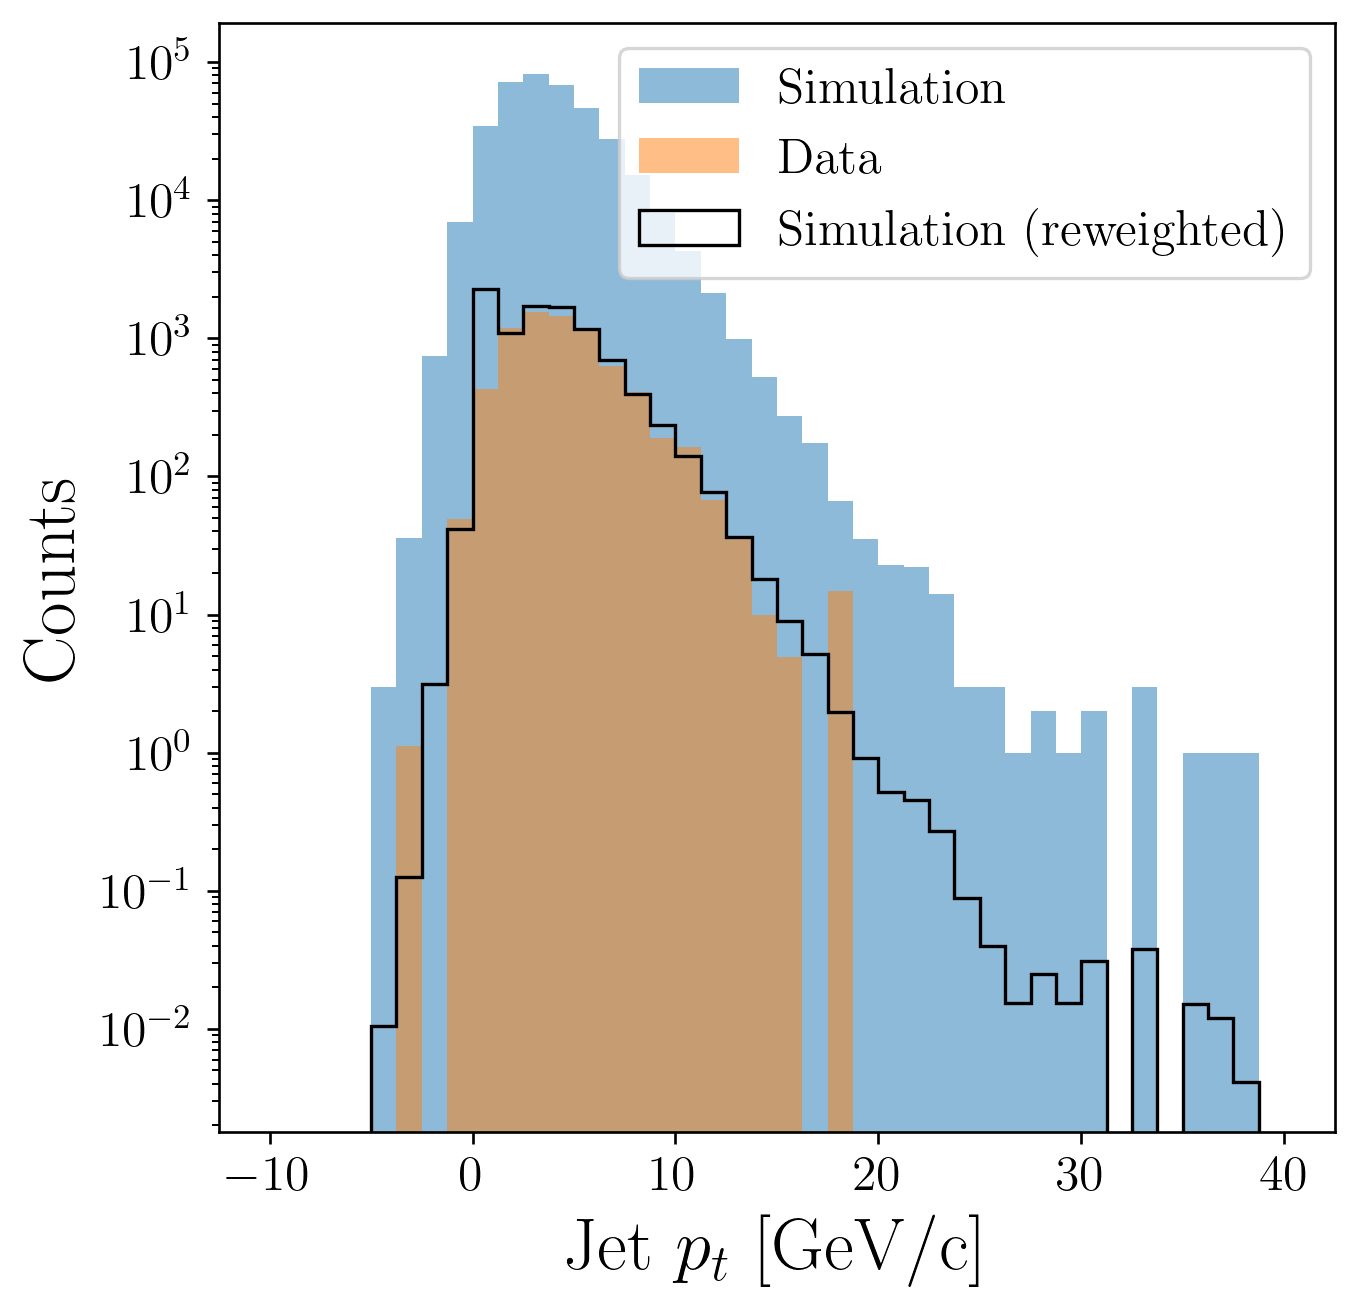

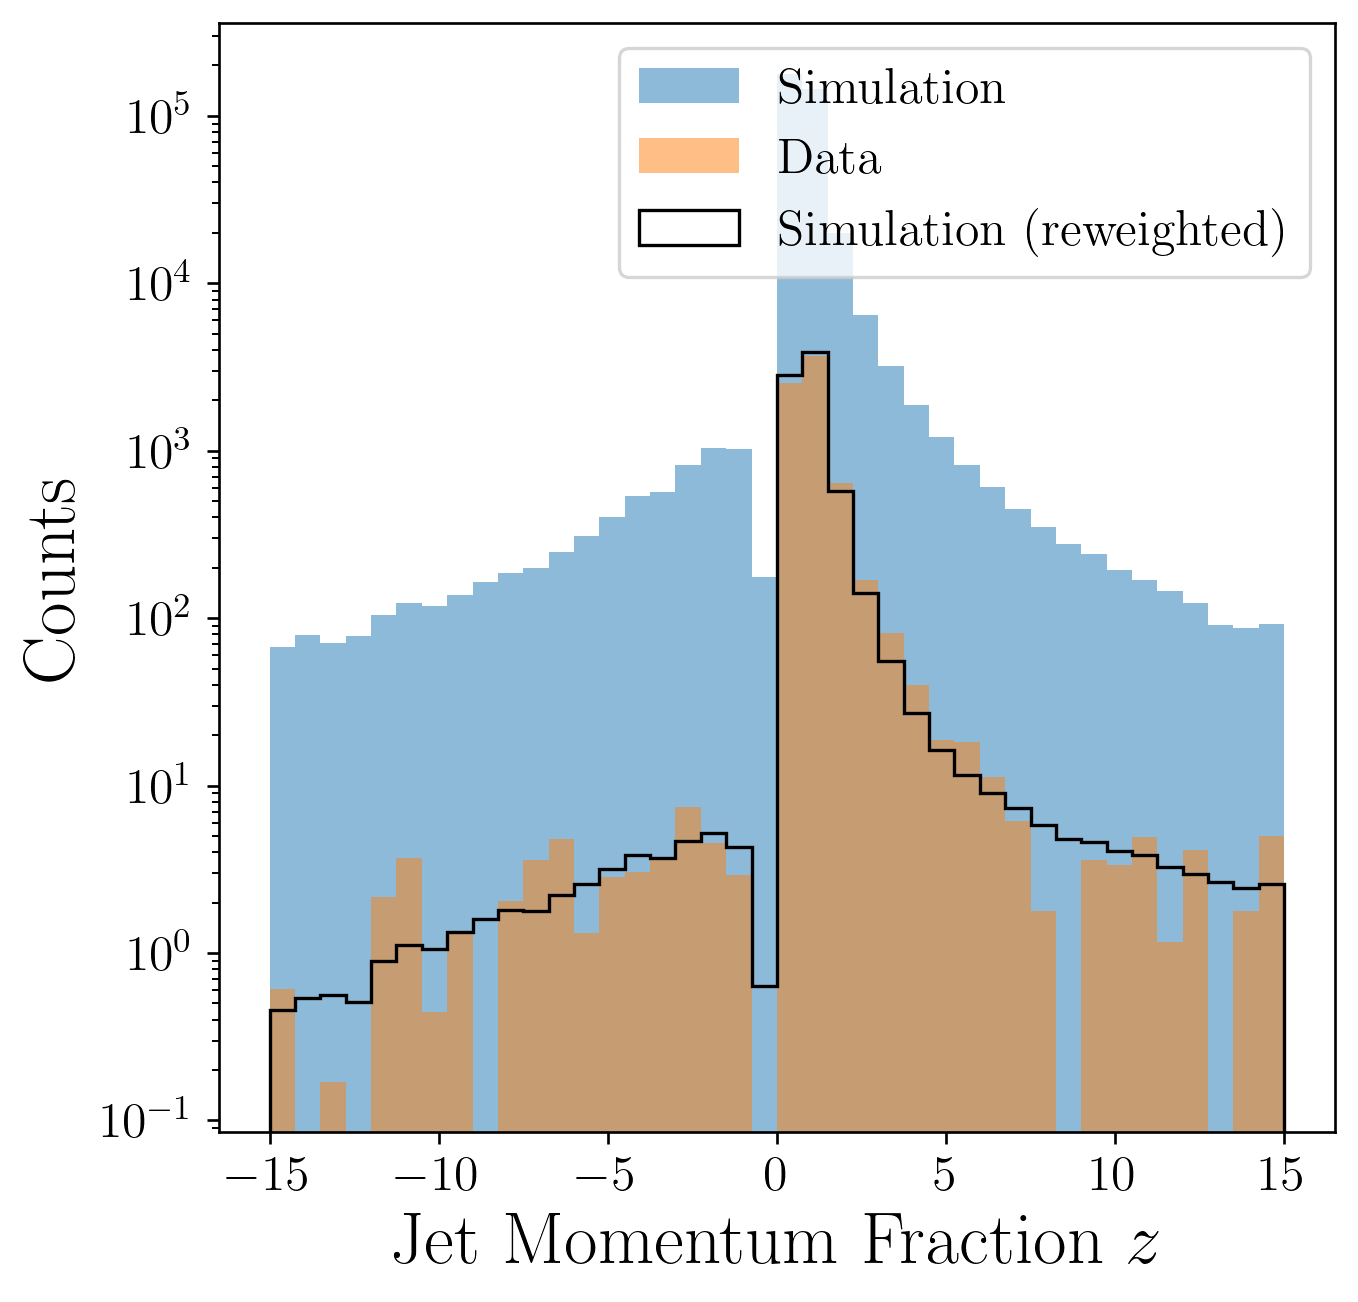

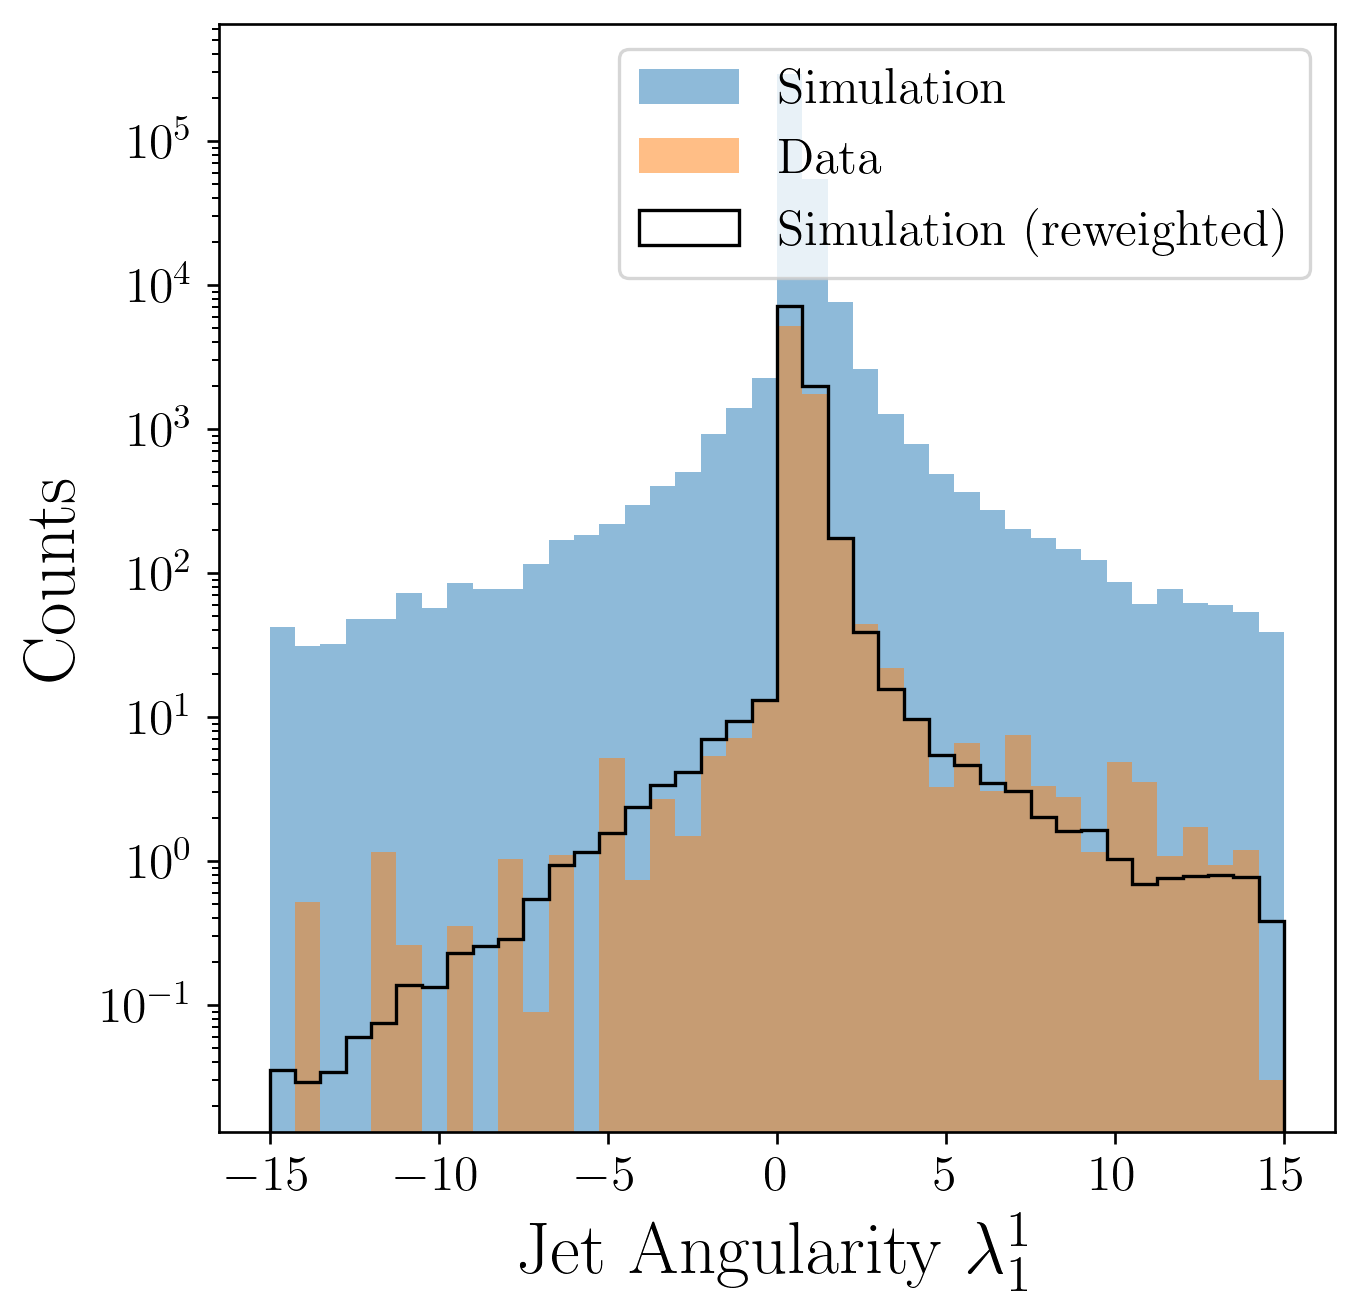

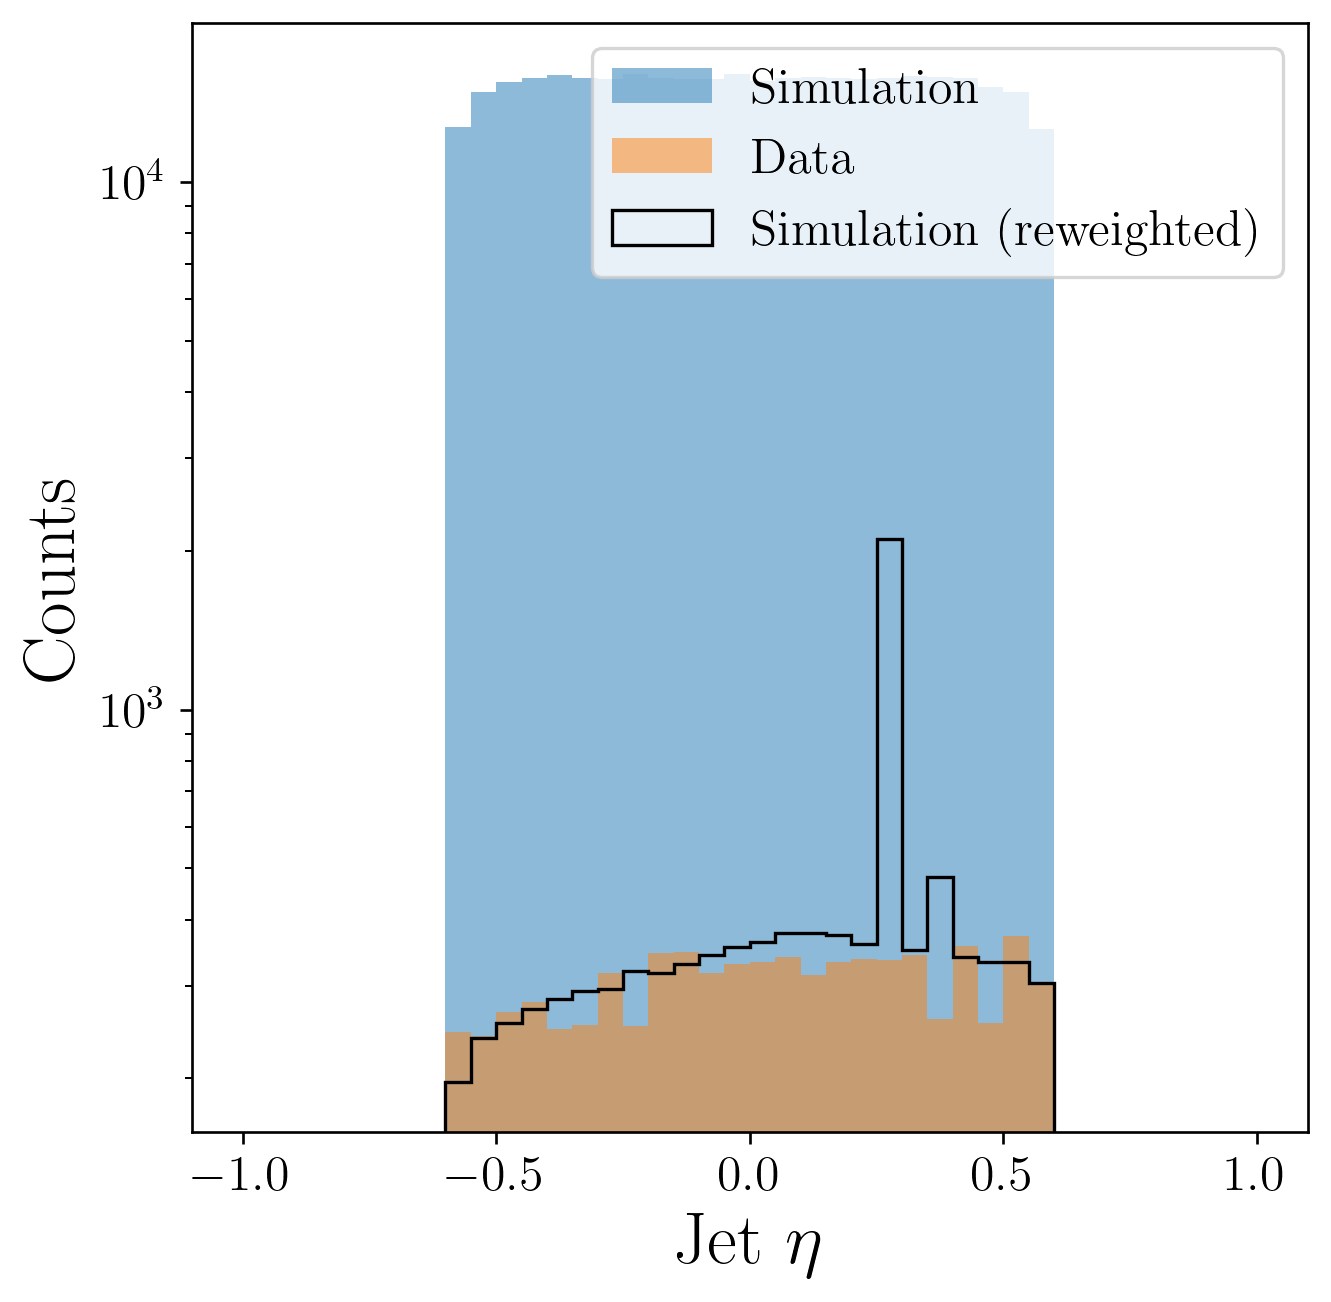

In [22]:
wdata = weights[selectedIteration,0,:] #weights after last iteration for pull after step 1

# for i,(obkey,ob) in enumerate(obs.items()):
# terate only in those observables which are in features:
for obkey,ob in obs.items():
    if obkey not in features:
        continue
    ndata=len(testReco)
    nsim=len(trainReco)
    norm = nsim/ndata
    norm=0.5*norm
    norm=1
    plt .rcParams['figure.figsize'] = (6,6)
    plt .rcParams['figure.dpi'] = 240

    fig, ax = plt.subplots()
    
   
    ax.hist(trainReco[obkey], bins=ob['bins_det']   , **plot_style_2, label='Simulation')
    ax.hist(testReco[obkey], bins=ob['bins_det'], **plot_style_2, label='Data ', weights=norm*testWts)
    ax.hist(trainReco[obkey], bins=ob['bins_det'], histtype="step", label='Simulation (reweighted)',color="black",weights=norm*wdata)
    # legend = ax.legend(loc='upper left',    frameon=False)
    # plt.setp(legend.get_title(), multialignment='center')
    plt.yscale('log')
    plt.xlabel(ob['xlabel'])
    plt.ylabel(ob['ylabel'])
    plt.legend()
    fig.show()
    # fig.savefig('reweight_{}.pdf'.format(obkey), bbox_inches='tight')

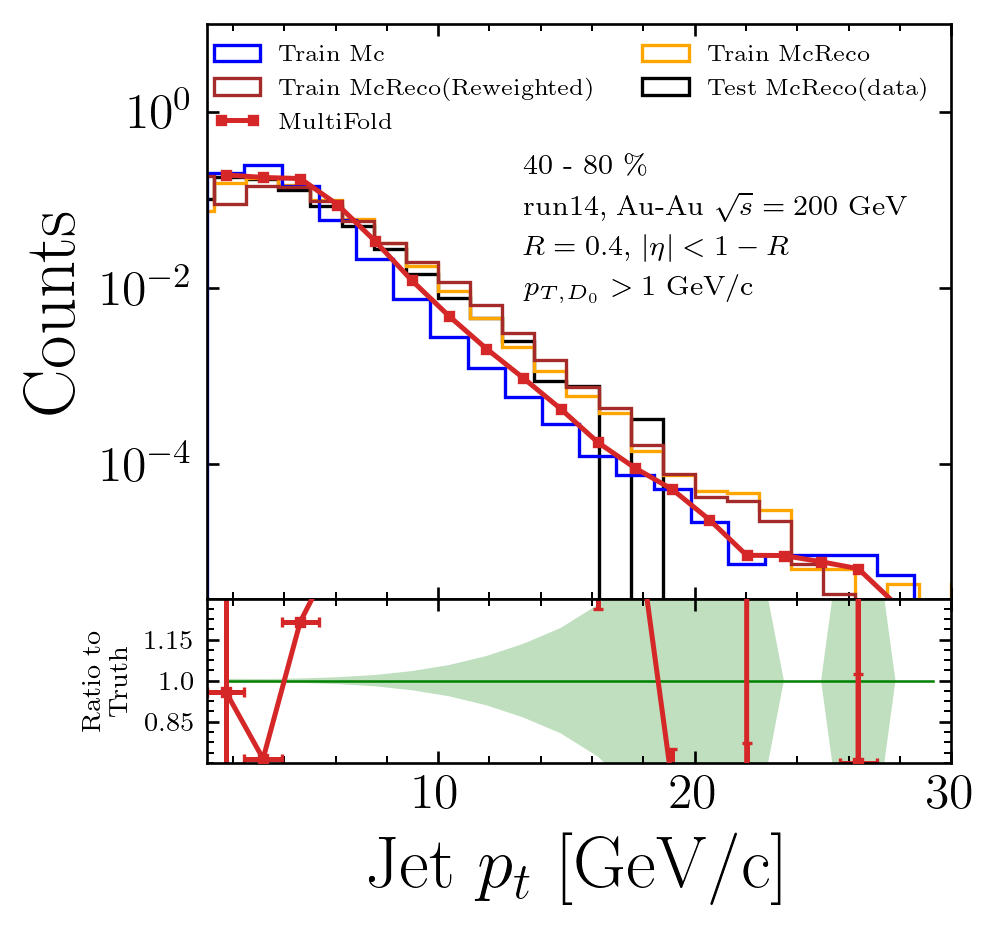

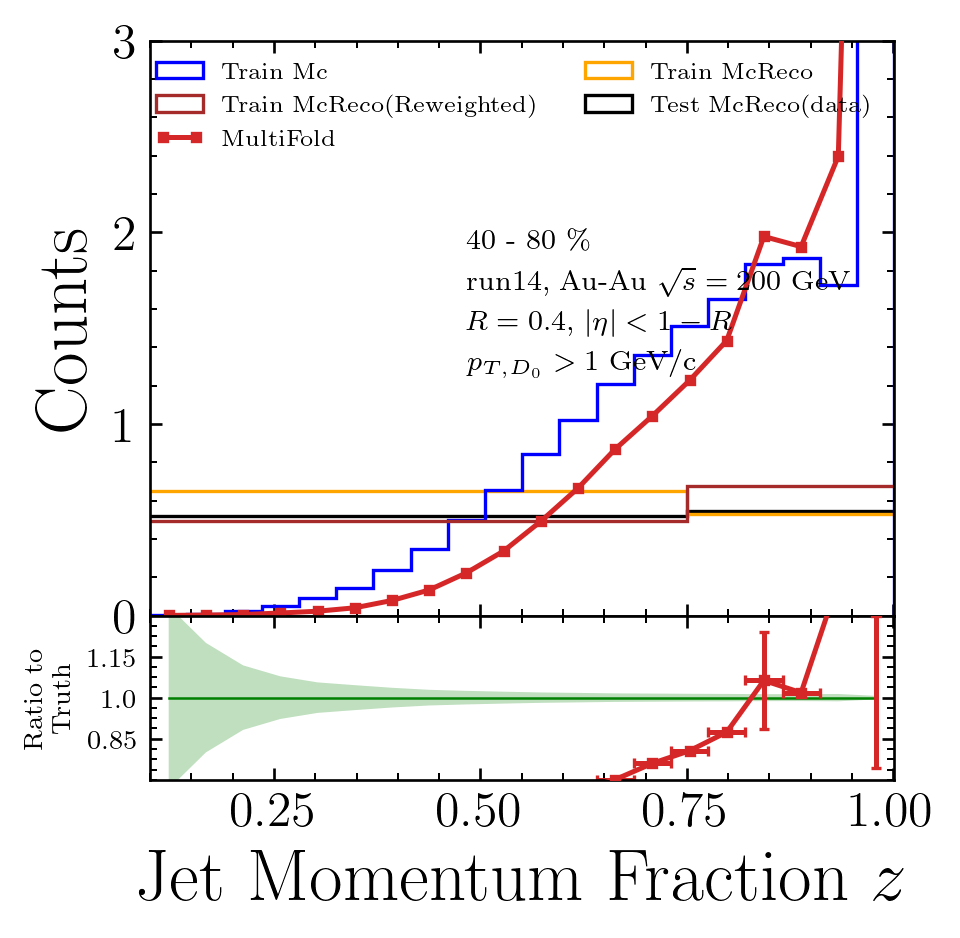

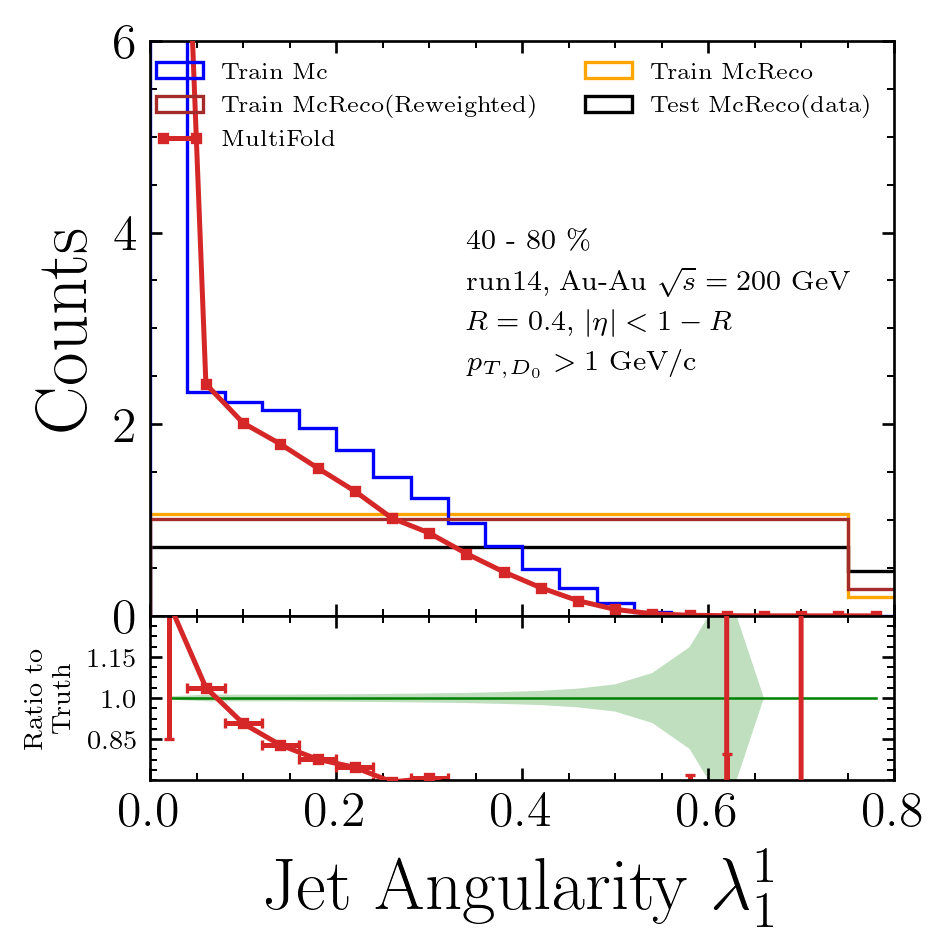

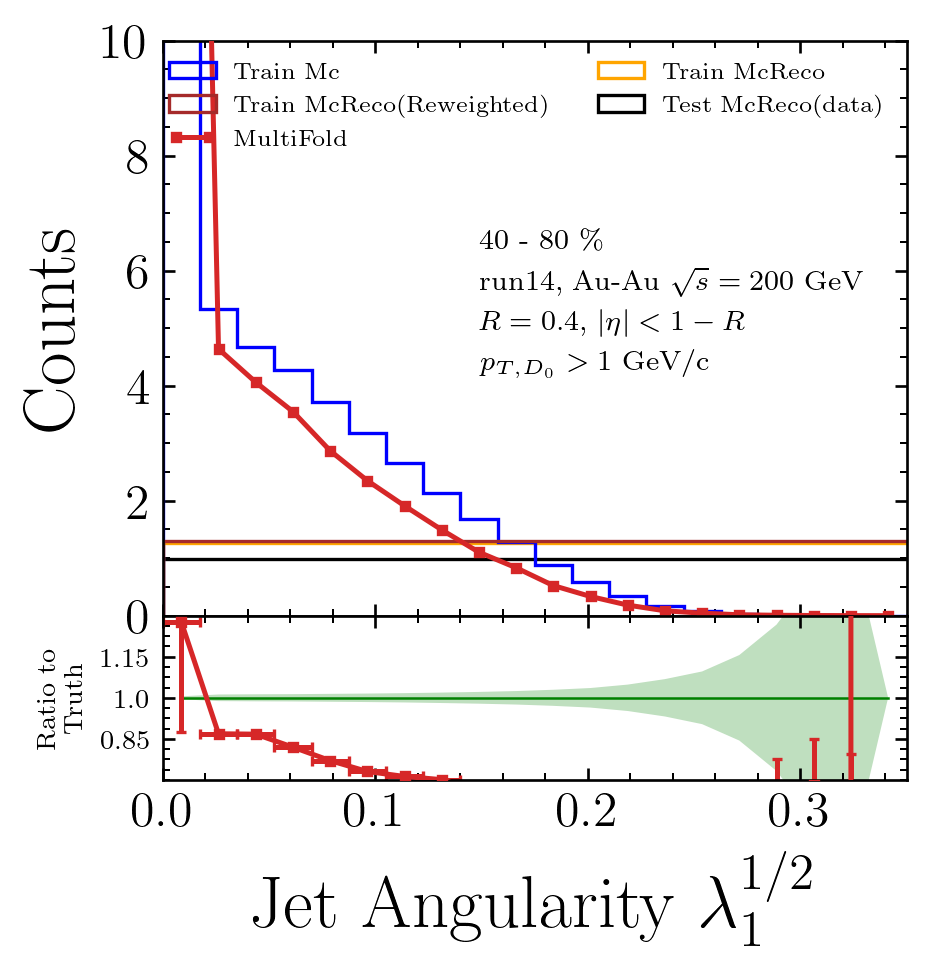

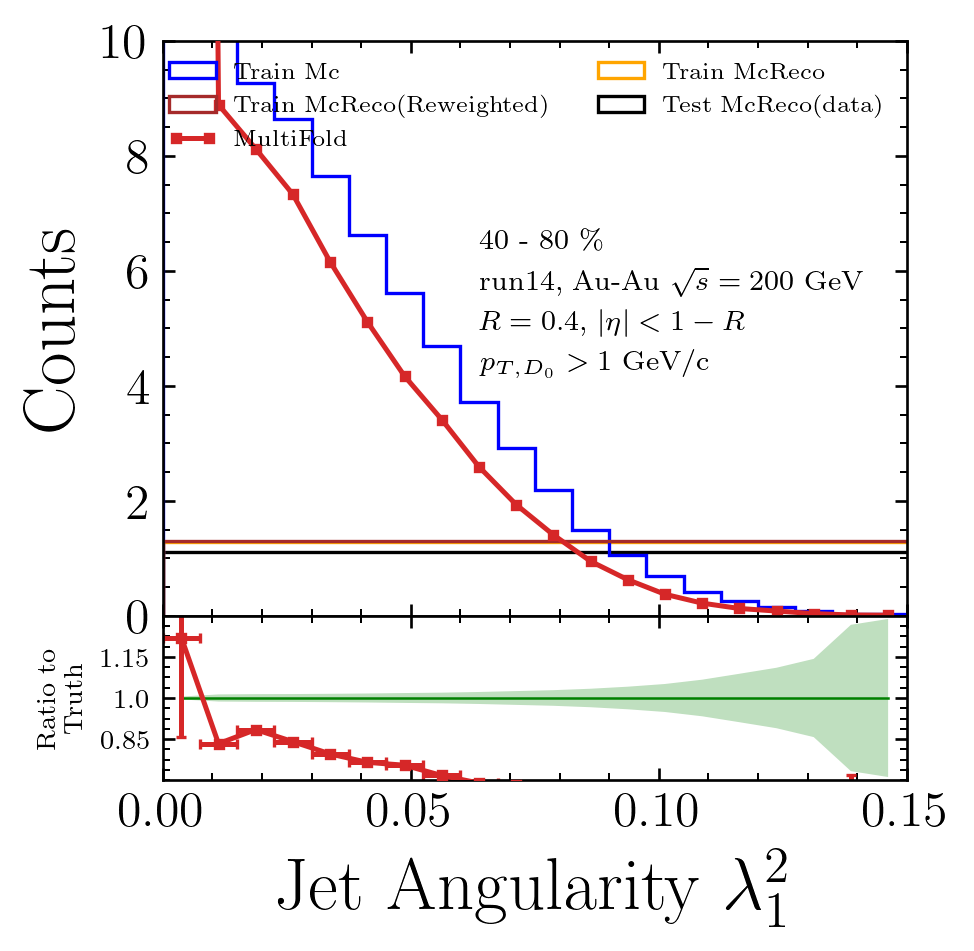

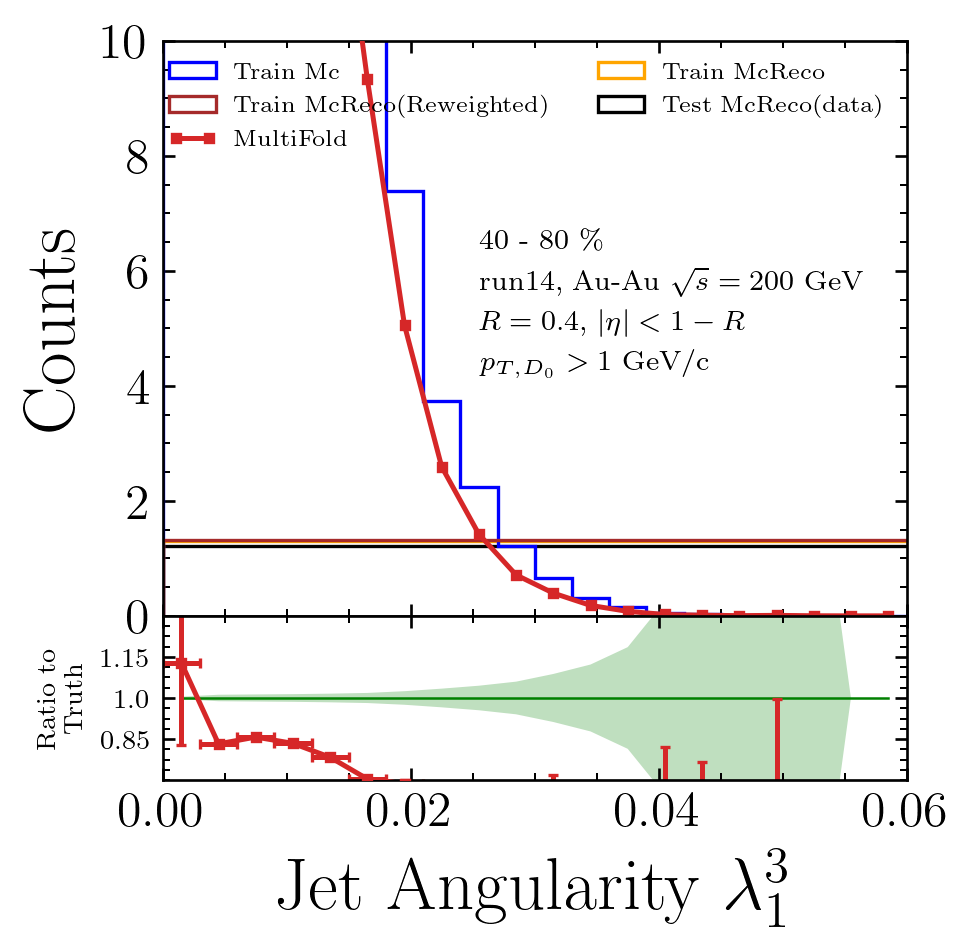

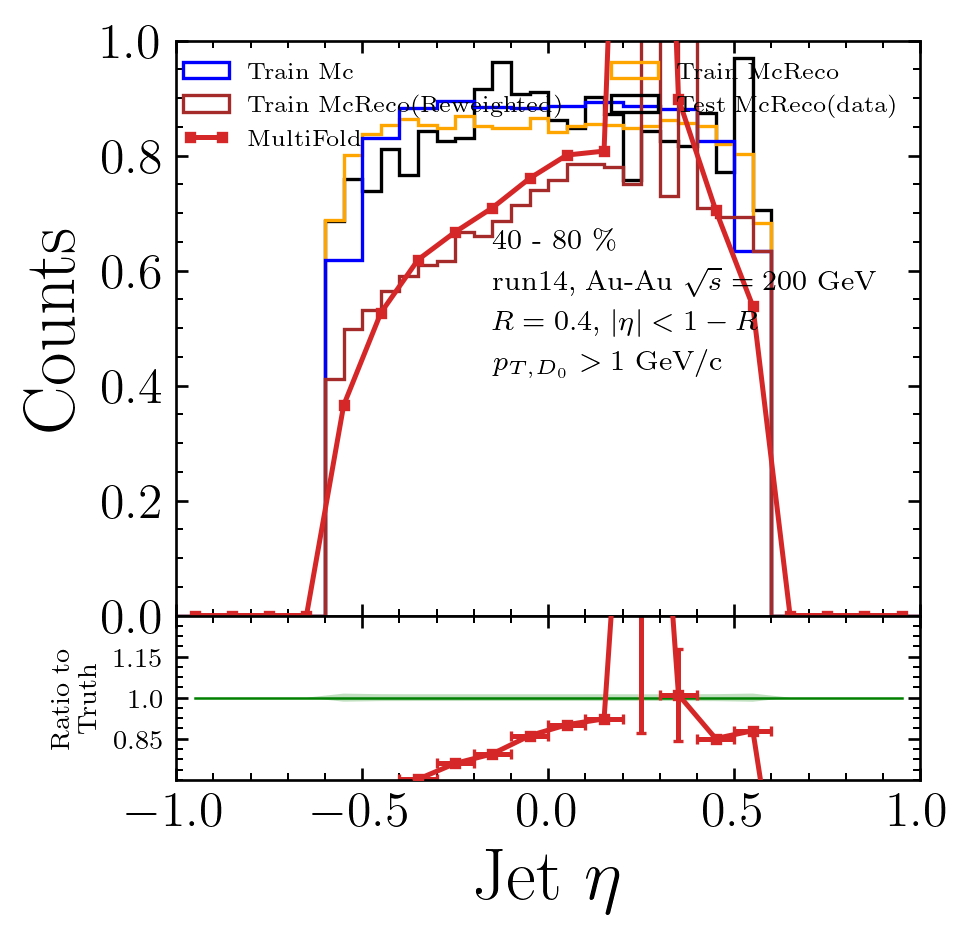

In [28]:
wdata = weights[selectedIteration,0,:] #weights after last iteration for pull after step 1

for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob)
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])


    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='Test McReco(data)', **hist_style)


    # plot the "sim" histogram of the observable
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Train McReco', **hist_style)

    ax0.hist(ob['genobs'], bins=ob['bins_mc'], color='blue', label='Train Mc', **hist_style)

    # # plot the "sim" histogram of the observable
    # ax0.hist(ob['truthobs'], bins=ob['bins_mc'], color='green', label='Test Mc(truth)', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='brown', weights=wdata, label='Train McReco(Reweighted)', **hist_style)

    # # # plot the "gen" histogram of the observable
    # ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)

    # # plot the "truth" histogram of the observable
    # ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    # Plot the Unfolded Distributions of the Observable
    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=wdata, bins=ob['bins_mc'], density=True)[:2]
    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='MultiFold')

    # Plot the Ratios of the OmniFold distribution to truth (with statistical uncertainties)

    of_ratio = of_histgen/(ob['truth_hist']+ 10**-50)
    ax1.plot(ob['midbins_mc'], of_ratio, **omnifold_style)

    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)

    of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
    
    ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)

    ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                              color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [2, 3, 4, 1, 0] 
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol,fontsize = 7)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.07, ax=ax0,
    # centrality label
                  line_0=r'{} - {} \%'.format(centralityBins[0], centralityBins[1]), 
                  line_1=r'run14, Au-Au $\sqrt{s}=200$ GeV',
                  line_2=r'$R=0.4$, $|\eta|<1-R$',
                  line_3=r'$p_{T,D_0}>1$ GeV/c')

    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig('MultiFold_{}.pdf'.format(obkey), bbox_inches='tight')
    plt.show()
